In [50]:
#imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

from sklearn import preprocessing

import time

##### Let us see if there are some cleaning activity that we can perform(except outlier removal) before some visualization. This is important because we end up unnecessary observation because of raw data.

In [3]:
def dummy():
    df = pd.read_csv(r'C:\Users\padmaraj.bhat\OneDrive - Accenture\Downloads\TrainData_PA.csv')
    print('Initial df size', df.shape)
    
    print('Duplicates size', df[df.duplicated()].shape)
    
    print('NaN columns :', df.columns[df.isna().any()].tolist())
    
    df = df.fillna('NA')
    print('NaN columns (post fillna):', df.columns[df.isna().any()].tolist())
    print('Duplicates size (post fillna)', df[df.duplicated()].shape)
    
    key_columns = [x for x in list(df) if x != 'time']
    print("Duplicates without considering *time* feature : ", df[df.duplicated(key_columns)].shape)
    
dummy()

Initial df size (18203, 40)
Duplicates size (60, 40)
NaN columns : ['county', 'zipcode', 'address', 'property_type']
NaN columns (post fillna): []
Duplicates size (post fillna) (60, 40)
Duplicates without considering *time* feature :  (123, 40)


In [4]:
def getTheCleansedData():
    df = pd.read_csv(r'C:\Users\padmaraj.bhat\OneDrive - Accenture\Downloads\TrainData_PA.csv')
    df = df.fillna('NA').reset_index(drop=True)
    
    key_columns = [x for x in list(df) if x != 'time']
    df = df.sort_values(by='time', ascending=False).reset_index(drop=True)
    
    df = df.drop_duplicates(key_columns,keep='first').reset_index(drop=True)
   
    colorMap = {'Condo': 'red', 'SFR': 'green', 'Duplex': 'black', 'NA': 'blue', 'Quadplex': 'yellow', 'Triplex':'orange', }
    df['property_type_color_map'] = df.property_type.apply(lambda x : colorMap[x])
    
    return df.reset_index(drop=True)
df = getTheCleansedData()
print(df.shape,df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18080 entries, 0 to 18079
Data columns (total 41 columns):
county                     18080 non-null object
city                       18080 non-null object
zipcode                    18080 non-null object
address                    18080 non-null object
state                      18080 non-null object
rent                       18080 non-null int64
latitude                   18080 non-null float64
longitude                  18080 non-null float64
cemetery_dist_miles        18080 non-null float64
nationalhighway_miles      18080 non-null float64
railline_miles             18080 non-null float64
starbucks_miles            18080 non-null float64
walmart_miles              18080 non-null float64
hospital_miles             18080 non-null float64
physician_dist_miles       18080 non-null float64
dentist_dist_miles         18080 non-null float64
opt_dist_miles             18080 non-null float64
vet_dist_miles             18080 non-null float6

#### Going by the Udacity project review metrics:
#### 1. Univariate Analysis 

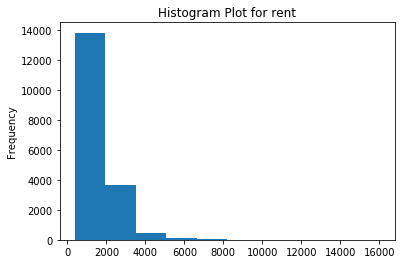

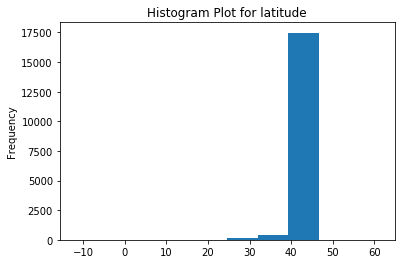

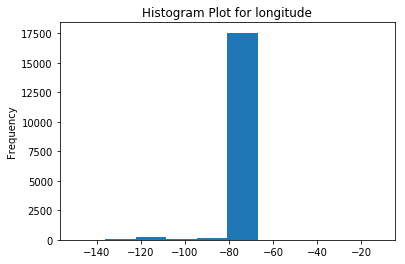

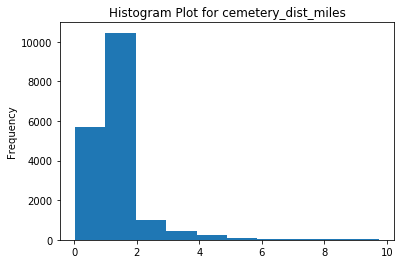

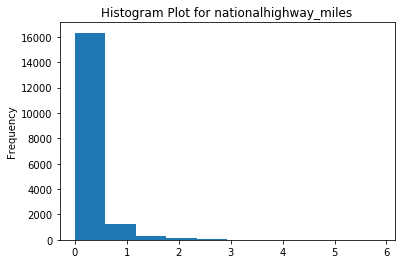

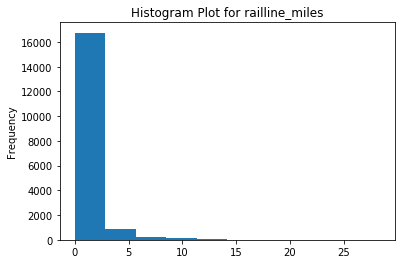

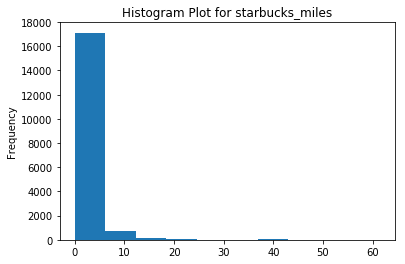

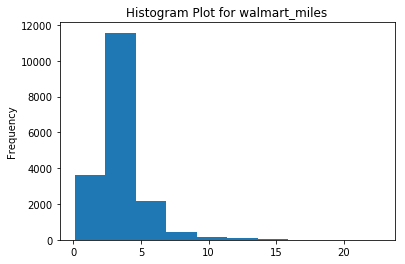

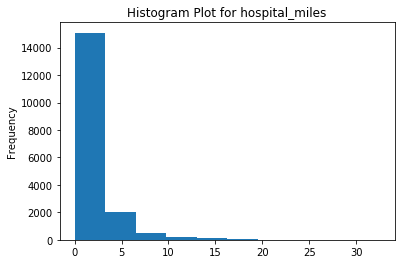

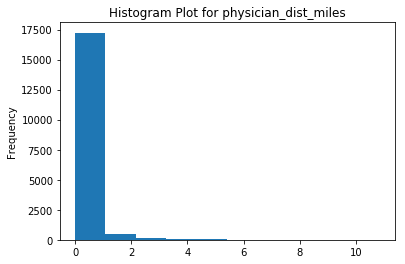

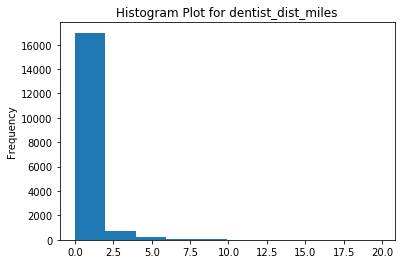

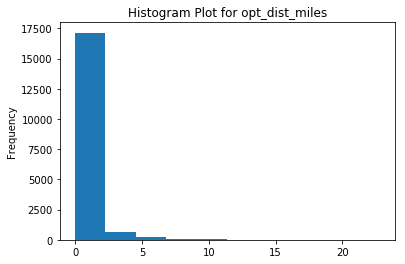

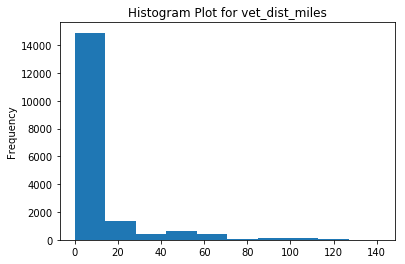

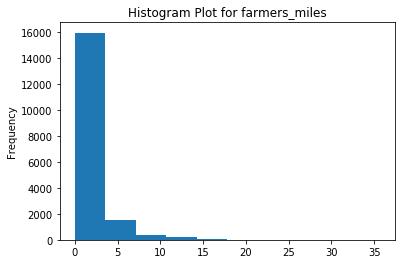

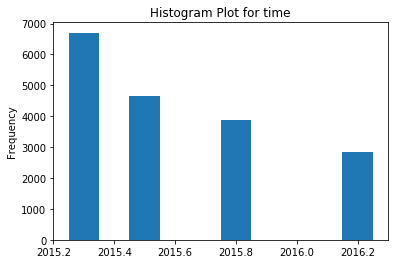

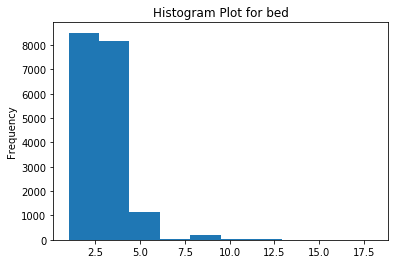

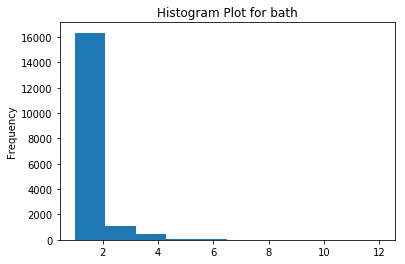

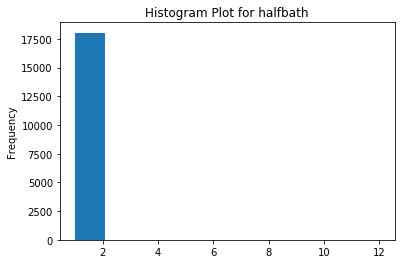

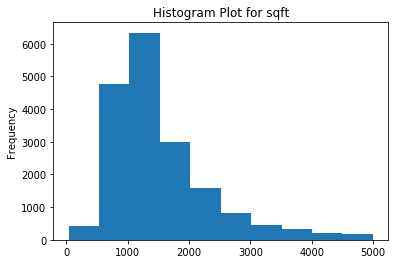

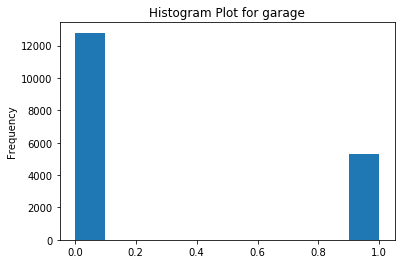

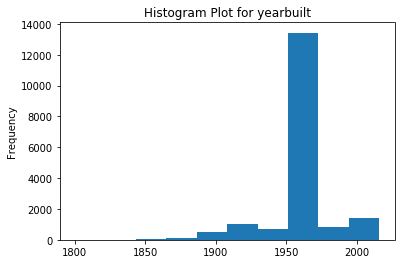

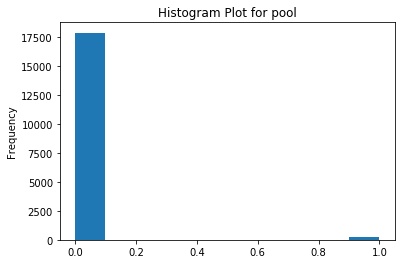

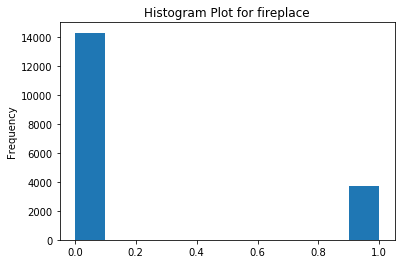

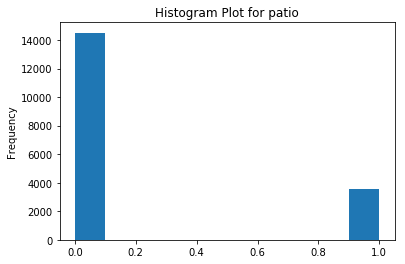

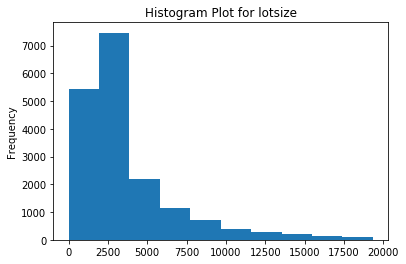

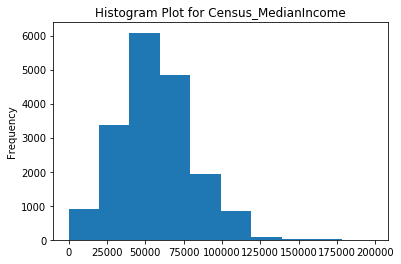

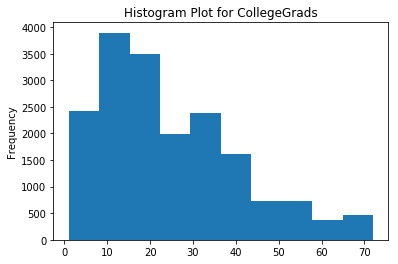

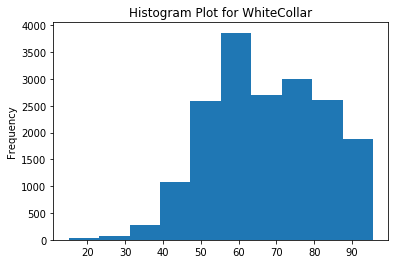

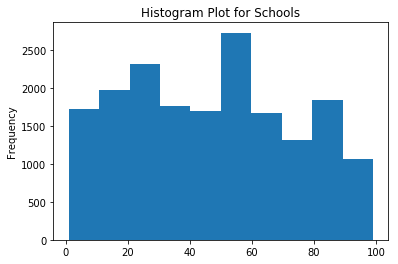

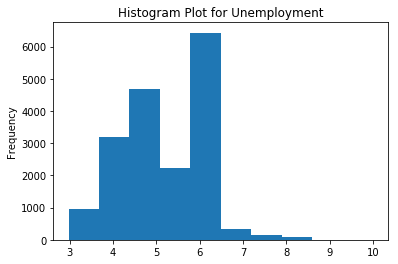

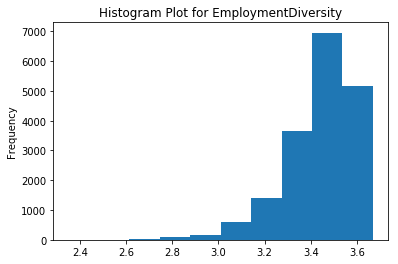

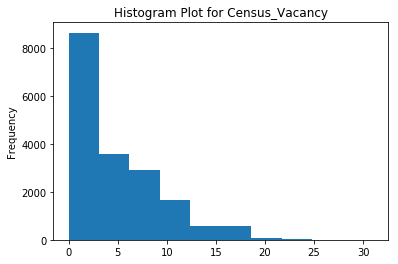

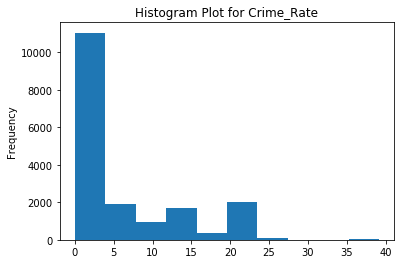

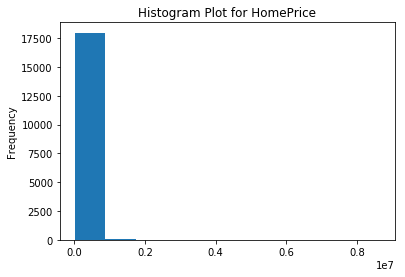

In [18]:
for c in list(df):
    if df[c].dtype in ['int64','float64']:
        
        df[c].plot(kind='hist',title='Histogram Plot for '+c)


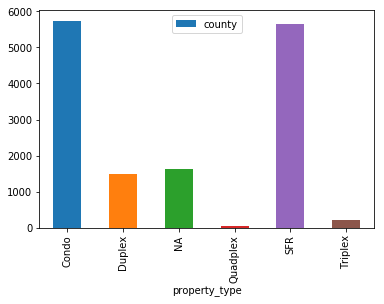

In [22]:
def plotPropertyTypeHist(df):
    temp = df.drop_duplicates(['longitude','latitude']).reset_index(drop=True)
    temp2 = temp.groupby('property_type').agg('count').reset_index()[['property_type','county']]
    temp2.plot.bar('property_type','county')
plotPropertyTypeHist(df)

##### Following require boxcox transformations: (skewness is huge)
* Rent
* distances : 'cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', 'starbucks_miles', 'walmart_miles', 'hospital_miles', 'physician_dist_miles', 'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', 'farmers_miles'
* property compositional attributes : 'bed', 'bath', 'halfbath'
* yearbuilt
* lotsize
* Census_MedianIncome
* EmploymentDiversity
* Census_Vacancy
* Crime_Rate
* HomePrice

##### Folllowing requires min max scaling or we can opt boxcox: (less skewness in the data)
* sqrt
* CollegeGrads
* WhiteCollor
* Schools
* Unemployment

##### Analysis:
* 'time' Plot indicates we need to take 2016.2 as the latest but also need to take older recods which are not in 2016.2. Just like we did in the cleaning activity earlier. We sorted in descending order for time and then removed duplicates keeping the first occurrence; thus retaining the latest.
* 'property' plot indicates 
* - there are fewer samples for Quadplex, Triplex and Duplex
* - 'NA' might not be a valid property type. It might indicate simply a missing value. Therefore, we have a losss of 14% of the total samples due to missing values.
* - that we may plan to have seperate predicting regression models for 'Condo' and 'SFR' because we have high samples to regression model. Higher samples higher is the confidence of the prediction. We may plan for a ensembled approach.

#### 2. Bivariate Analysis

##### We can broadly classify features into 3 areas.
* miles_columns : all features related to the distance between the property and respective entity.
* property_attribute : all features that make up the property
* education_column : all features which are related to school, college and jobs. Crime_Rate is also being linked to the list because crime is assumed to be houseold related and nothing related to online scams happening remotely.

In [63]:
miles_columns = ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', 'starbucks_miles', \
                        'walmart_miles', 'hospital_miles', 'physician_dist_miles', 'dentist_dist_miles', 'opt_dist_miles', \
                        'vet_dist_miles', 'farmers_miles'
                     ]

property_attribute_continuous_column = ['bed', 'bath', 'halfbath', 'sqft', 'yearbuilt', 'lotsize']

property_attribute_category_column = ['property_type', 'garage', 'pool', 'fireplace', 'patio']

education_columns = ['Census_MedianIncome', 'CollegeGrads', 'WhiteCollar', 'Schools', 'Unemployment', \
                      'EmploymentDiversity','Census_Vacancy', 'Crime_Rate']

In [59]:
def plotColumnsVsAvgRent(df,columns_list,bar=0): 
    if bar == 0:
        for c in columns_list:
            df.groupby(c).agg('mean').reset_index().plot(c,'rent', title=c+' vs Average Rent' ,legend=None)
    else:
        for c in columns_list:
            df.groupby(c).agg('mean').reset_index().plot.bar(c,'rent', title=c+' vs Average Rent' ,legend=None)

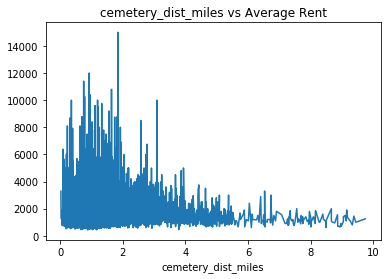

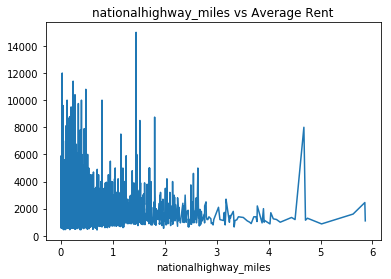

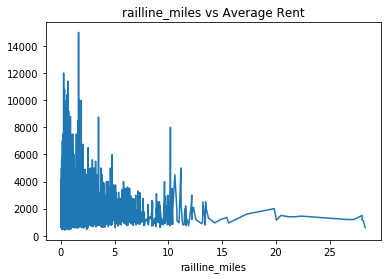

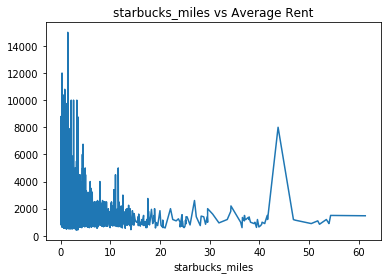

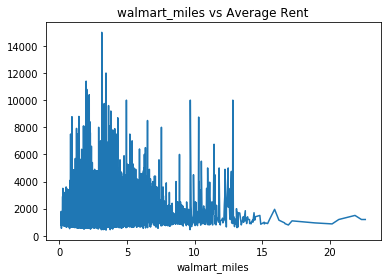

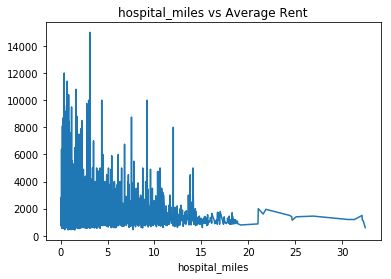

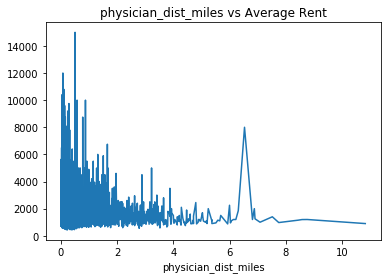

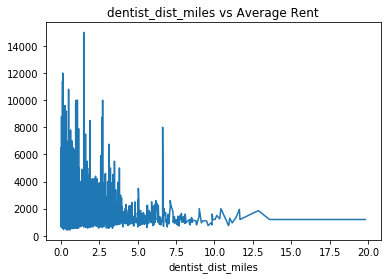

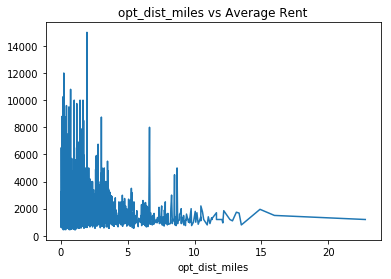

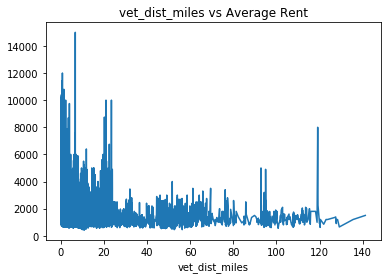

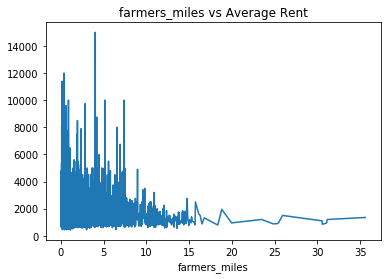

In [56]:
plotColumnsVsAvgRent(df, miles_columns)

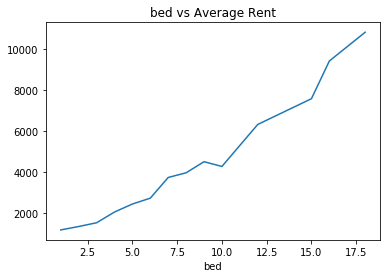

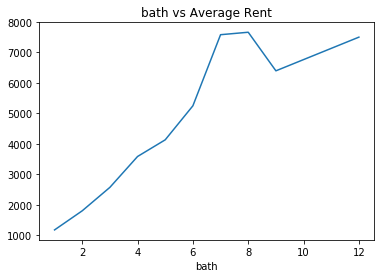

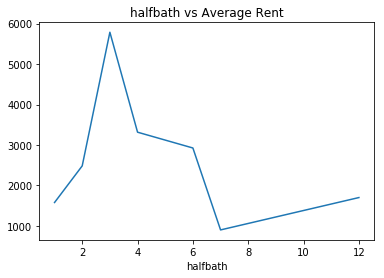

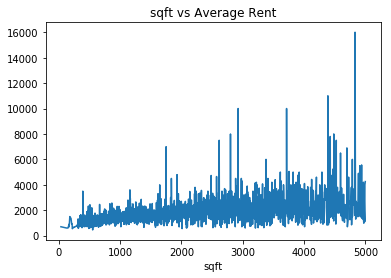

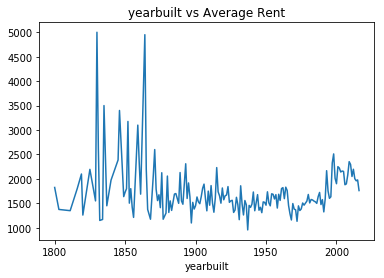

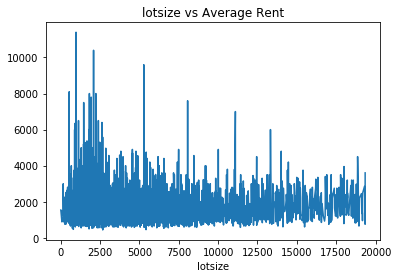

In [62]:
plotColumnsVsAvgRent(df, property_attribute_continuous_column)

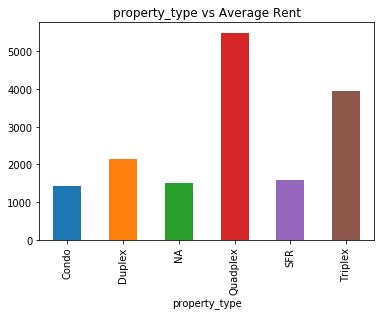

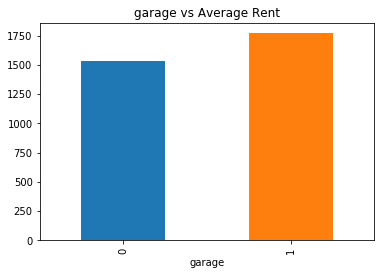

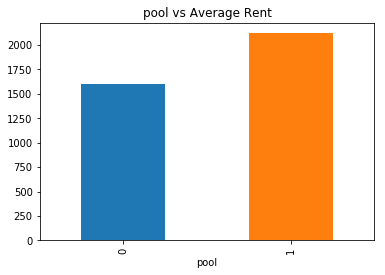

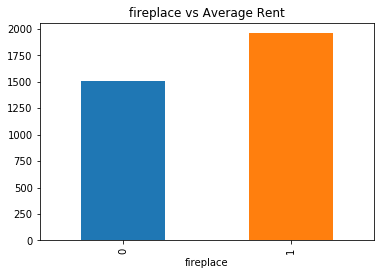

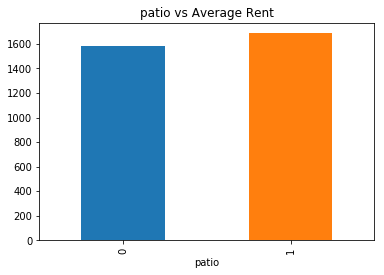

In [60]:
plotColumnsVsAvgRent(df, property_attribute_category_column, 1)

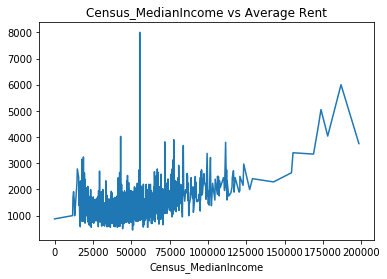

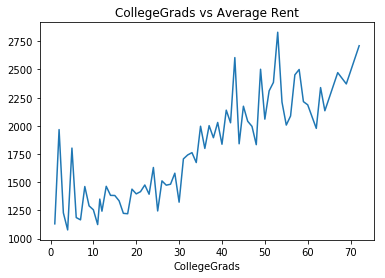

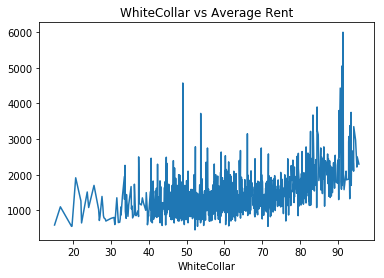

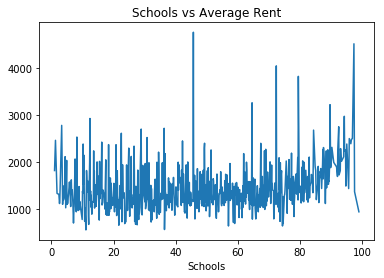

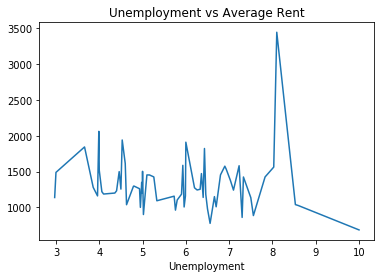

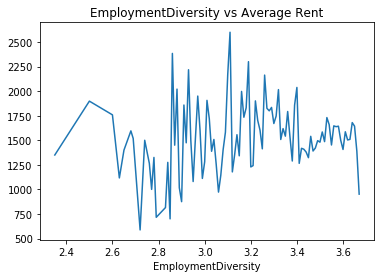

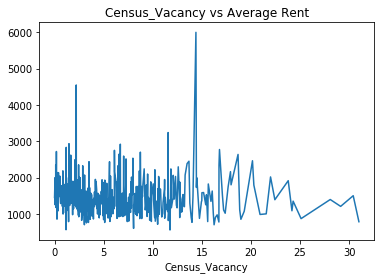

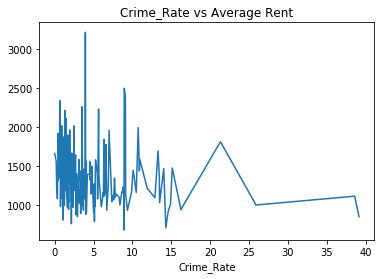

In [58]:
plotColumnsVsAvgRent(df, education_columns)

##### Analysis:
* Peakest rent is observed at around 2- 5 miles from the railline, nationalhighway etc.
* Increase in 'bed', 'bath' and 'sqft' increases 'rent'
* half bath is sort of out dated. People perhaps like to shit first and then immediately take bath ;) or couple go in together with one shitting and other bathing ... ROFL
* People like indoor space a lot and hence increase in lot size does not increases the rent. After all, it is a rented property, for a owned property you would want a spacious area both inside and outside.

* Rent does not depend on when was the house built; as long as it serves people need.
* More the aminity, higher the rent.

* More number white collar job, rent is high. In Bengaluru, owners loot when they get to know the tenants are from IT industry.

* Median income is not directly propertional to the average rent. Probably, people with high income opt to own the property rather to stay in rented house. We also see a peak in average rent for a median income around 55K. This does not fit our common sense at first go. 55K = around 5K per month but average rent is around 8K. The catch here is rent of a quadplex is being shared across the bed; number of people staying in the quadplex. Hence, we need to have the new feature rent/bed. We may replot everything with this new feature to understand the co relation better. During testing, we may multiply number of beds with that of predicted rent per bed to get the overall rent per complex.

* It is not very clear how 'Unemployment' is noted. As in does it include school or college students? If yes then the peak for '8' can be explained as people trying for the jobs paying rent high. Yet again, rent/bed would be more useful here.

* Cheap houses might not have good security and hence high crime rate.


### 3. Multi-variate Analysis

##### As indicated in the Bi-variate analysis, let us create a new feature rent per bed and re-plot the relation with various columns with respect to new feature.

##### NOTE:  For ease of comparison both plots: column vs rent and column vs rent/bed are placed together.

In [65]:
df['rent_per_bed'] = df['rent'] / df['bed']
df.head()

,county,city,zipcode,address,state,rent,latitude,longitude,cemetery_dist_miles,nationalhighway_miles,...,CollegeGrads,WhiteCollar,Schools,Unemployment,EmploymentDiversity,Census_Vacancy,Crime_Rate,HomePrice,property_type_color_map,rent_per_bed
0,NA,WEXFORD,NA,266 Clematis Dr Allegheny County,PA,2400,40.618200,-80.077600,1.019586,0.206222,...,21.0,66.57,48.3,5.10,3.48,3.42,2.400000,158051,red,800.0
1,LUZERNE,WILKES BARRE,18702,313 E Northampton St Luzerne County,PA,1050,41.237080,-75.878010,1.019586,0.206222,...,12.0,54.53,28.0,6.46,3.49,7.36,1.750000,158051,red,210.0
2,PHILADELPHIA,PHILADELPHIA,19127,4416 SAINT DAVIDS ST,PA,1200,40.027156,-75.224119,0.410680,0.080765,...,38.0,76.50,62.9,6.00,3.52,8.50,1.468825,218955,green,600.0
3,LYCOMING,MONTGOMERY,17752,1219 SAEGERS STATION RD,PA,895,41.183635,-76.838398,1.102881,0.223831,...,7.0,45.59,77.8,6.80,3.40,2.70,5.200000,161244,green,447.5
4,LYCOMING,WILLIAMSPORT,17701,500 7TH AVE,PA,1440,41.240303,-77.025660,0.758094,0.049964,...,13.0,57.33,59.6,6.80,3.50,5.16,5.263617,158051,red,720.0


In [72]:
def plotColumnsVsAvgRentPerBed(df,columns_list,bar=0): 
    if bar == 0:
        for c in columns_list:
            df.groupby(c).agg('mean').reset_index().plot(c,'rent_per_bed', title=c+' vs Average Rent Per Bed' ,legend=None)
            df.groupby(c).agg('mean').reset_index().plot(c,'rent', title=c+' vs Average Rent' ,legend=None)
    else:
        for c in columns_list:
            df.groupby(c).agg('mean').reset_index().plot.bar(c,'rent_per_bed', title=c+' vs Average Rent Per Bed' ,legend=None)
            df.groupby(c).agg('mean').reset_index().plot.bar(c,'rent', title=c+' vs Average Rent' ,legend=None)

C:\Users\padmaraj.bhat\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


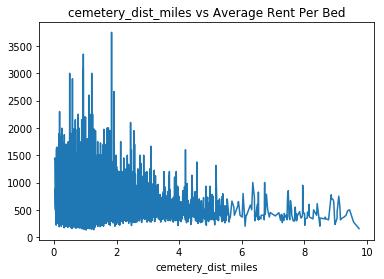

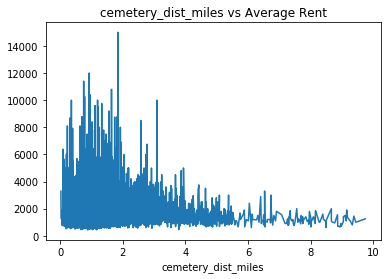

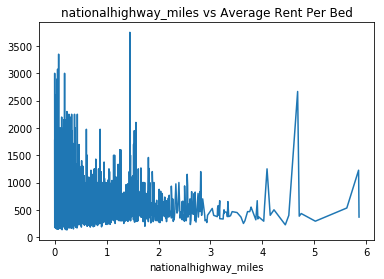

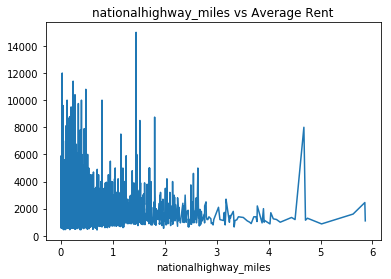

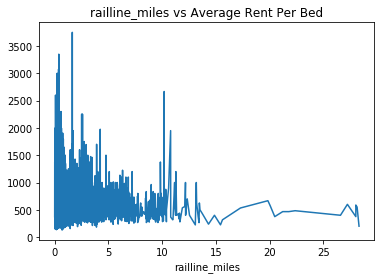

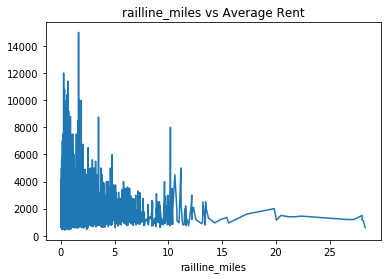

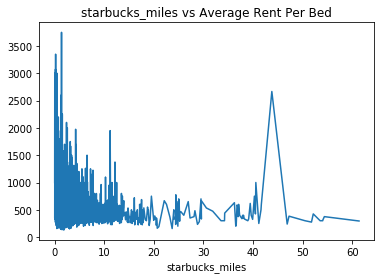

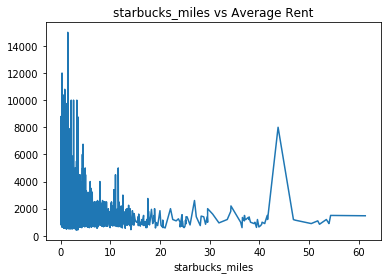

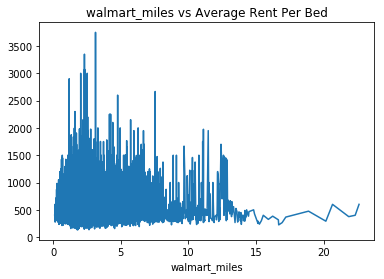

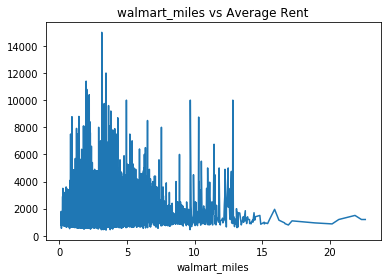

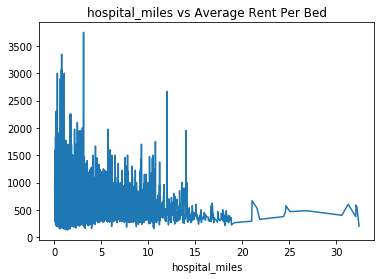

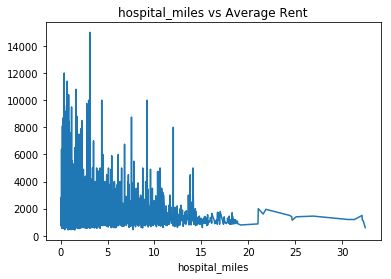

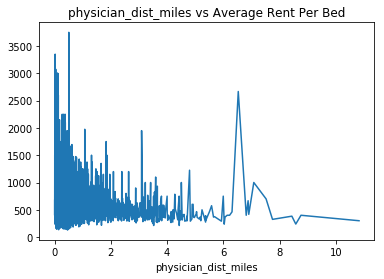

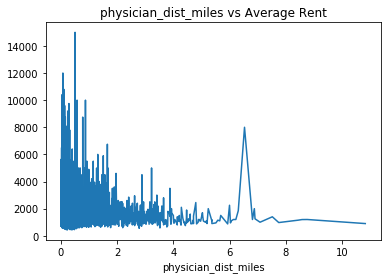

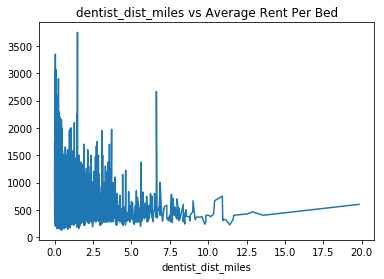

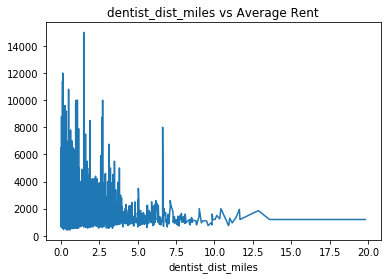

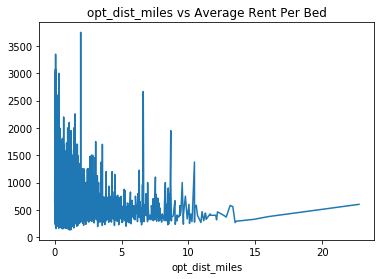

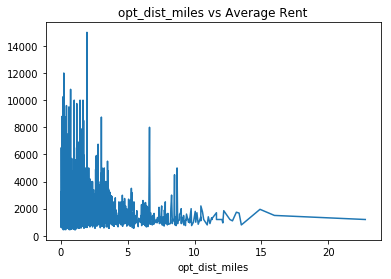

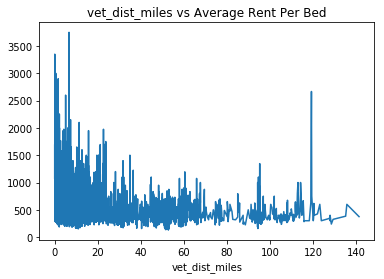

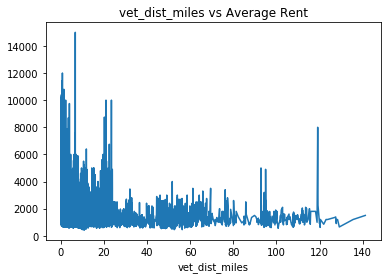

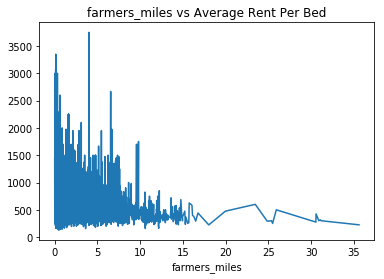

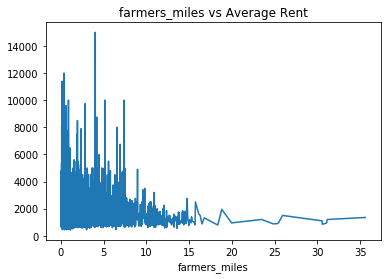

In [69]:
plotColumnsVsAvgRentPerBed(df,miles_columns)

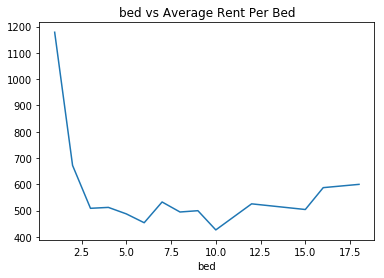

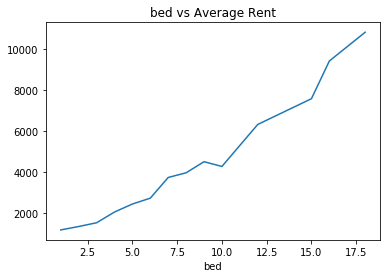

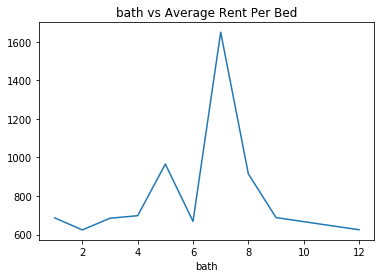

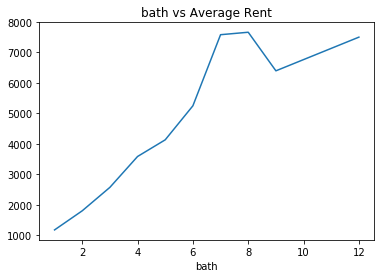

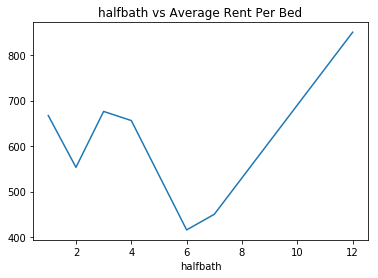

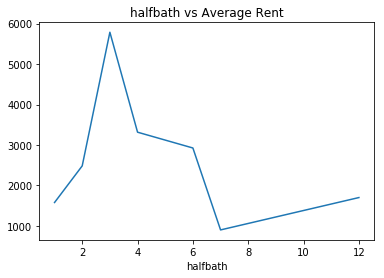

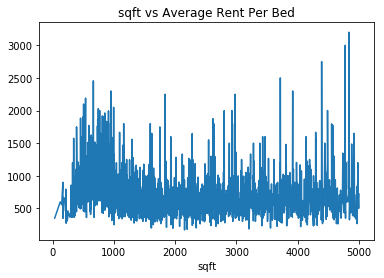

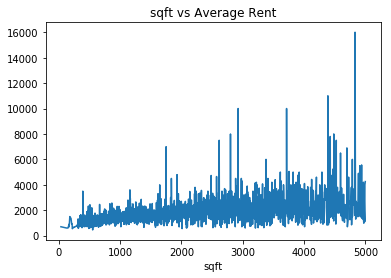

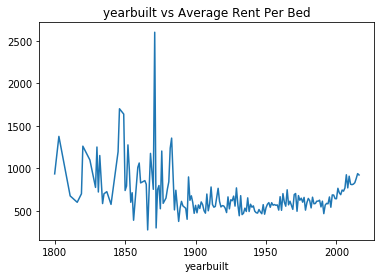

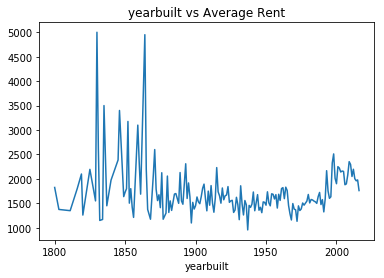

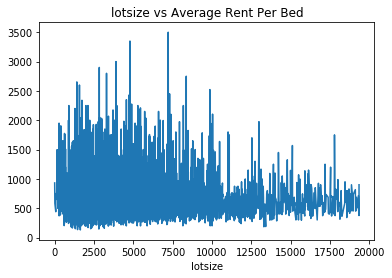

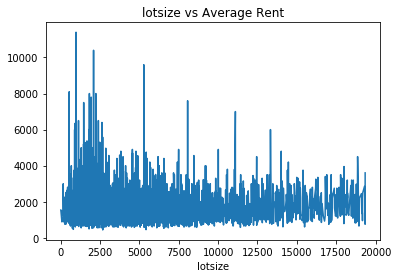

In [70]:
plotColumnsVsAvgRentPerBed(df,property_attribute_continuous_column)

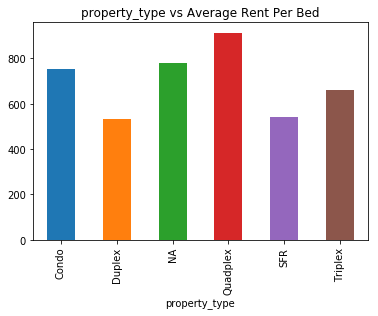

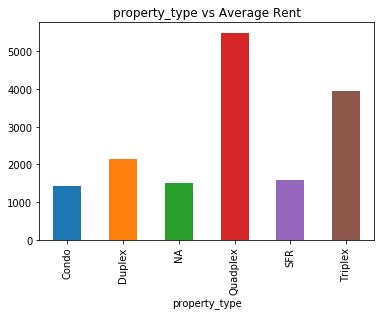

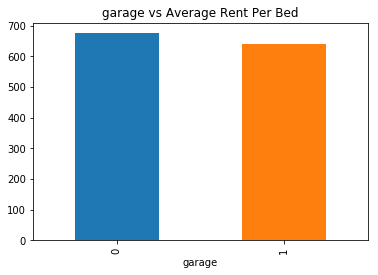

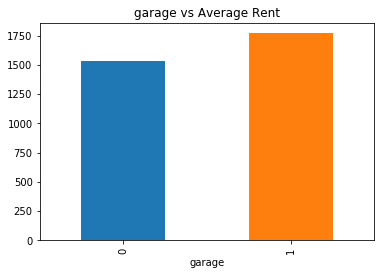

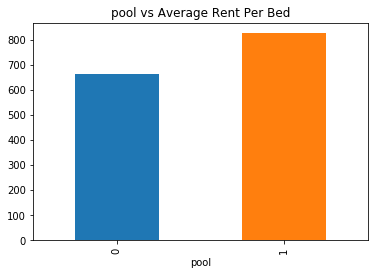

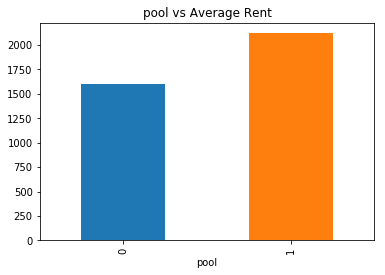

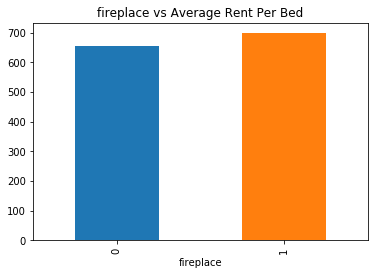

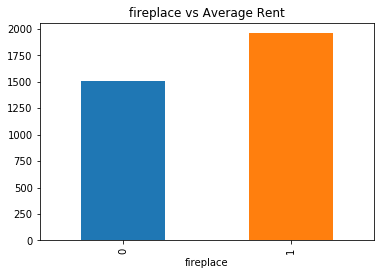

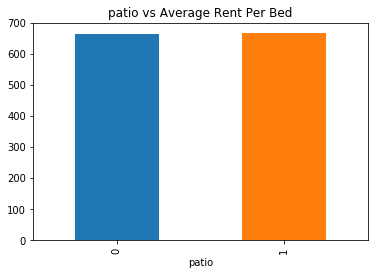

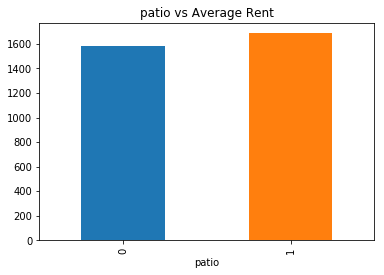

In [73]:
plotColumnsVsAvgRentPerBed(df,property_attribute_category_column,1)

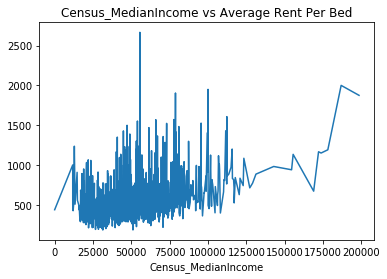

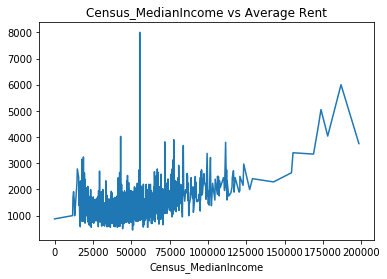

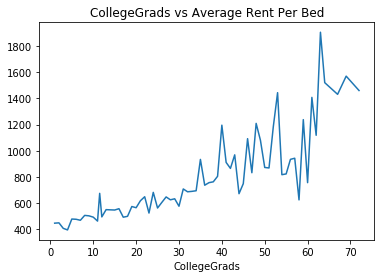

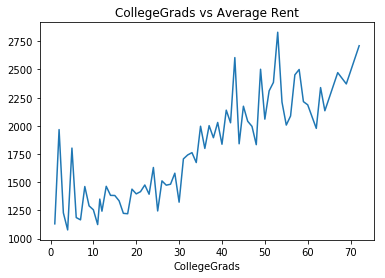

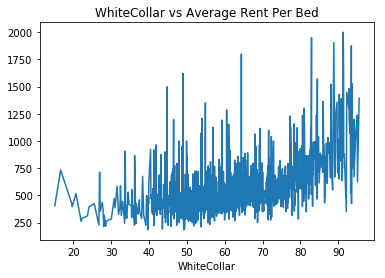

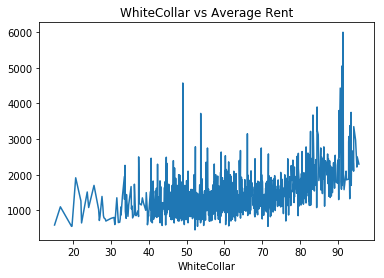

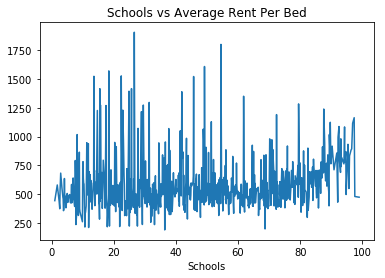

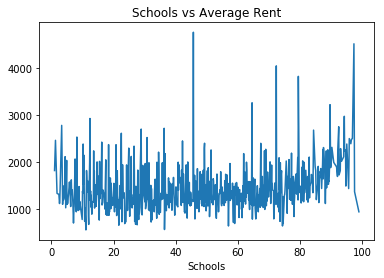

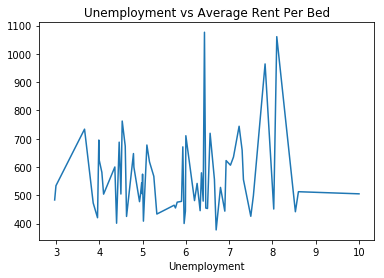

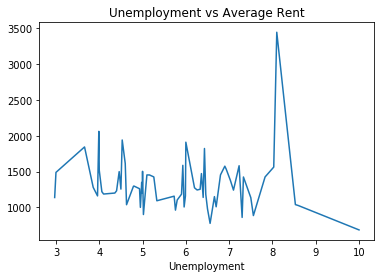

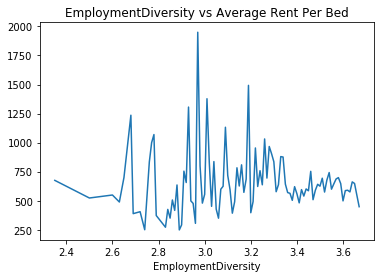

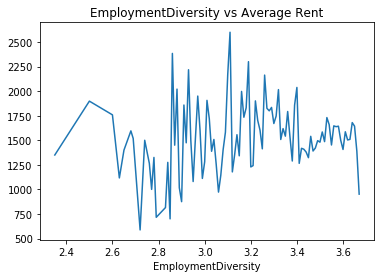

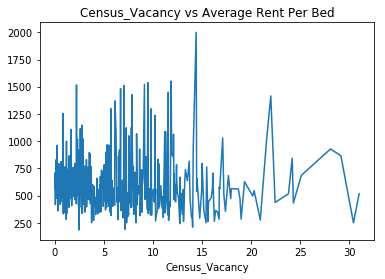

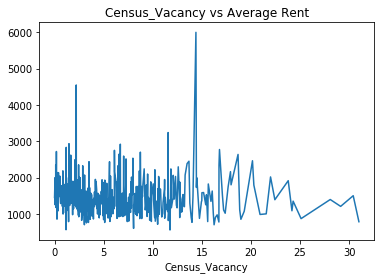

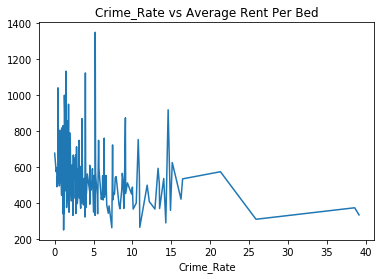

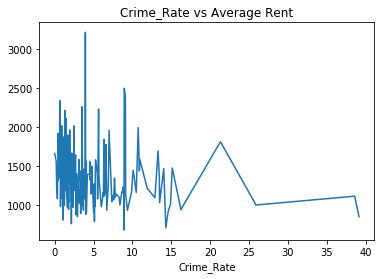

In [74]:
plotColumnsVsAvgRentPerBed(df, education_columns)

#### Multi-variate Analysis:
* There is no much difference between the plot miles vs rent to miles vs rent/bed
* More number of bed indicates that room or the property is being shared and hence rent/bed is low. Typically the place where students or bachelors seeking job or working bachelor prefers. Less number of property indicates the property is more likely to be SFR type and hence, contributes to luxry and hence rent amount.
* Bathroom plot is bit tricky. We see a peak for property with 7 bathrooms. This may be due to PG with AC /fire place sort of properties.
* halfbath plot really contradicts the bi variate analysis. halfbath may be helping 2 people to do thier tasks without a wait.
* Though we have no clear ideas as to why an year has peak rent , the plot helps us to generalize the fact that yearbuilt is neutral to rent.
* Older buildings did not have garage but that does not impacts the rent. Rest aminities increases the rent. History of the automobiles (https://en.wikipedia.org/wiki/History_of_the_automobile) indicates only mid of 19th century automobiles where popular.
* Now, we are clear that people with 5K per month mostly spend their half thier earning on the rent.
* College graduates are ready to share rooms and hence they have limitted rentable properties near college. This leads to high demand low supply situation and hence high rent per bed.
* Lesser school might indicate more space work offices and hence the peak is high when school count is low.
* Unemployment vs average rent per bed indicates that there may be people coming to the place in search of jobs. or Unemployment score calculation includes college grads. Census_vacancy plot also confirms this observation.
* high Employment_diversity value indicates various classes of jobs are around and hence rent applicant might not have same median income. low diversity indicates there are only few industry and median income may be biased to that perticular industry. Only at moderate, diversity we see a high rent. There might be jobs which might complement each other like IT industry and cab industry and construction business etc. This makes suitable place for living as there are labor availability for the required task.

##### We have highest rent in the year : 1960

In [ ]:
#let us plot the hot in mind
year = list(df[df.rent == df['rent'].max()]['yearbuilt'])[0]
#y_ticks = (df.rent.min() + df.rent.max())/4
y_ticks = list(np.arange(df.rent.min(), df.rent.max(), 3000))
y_ticks.append(df.rent.max())

fig, ax = plt.subplots()
ax.axhline(df['rent'].max(),color='r',lw=1)
ax.axvline(year,color='r',lw=1)
plt.xticks(np.arange(df.yearbuilt.min(), df.yearbuilt.max()+1, 20),rotation=45)

plt.yticks(y_ticks)


plt.scatter(df['yearbuilt'],df['rent'])
plt.show()

##### * Till 1900 the data are not so reliable or stable.  i.e. it has to fluctuation when observed in the plot and hence there is no regular pattern there.
##### * And Also, 1960 highest rent seems like out of the blue. Someone really got lucky or it is an data entry error. It is a outlier for sure.

In [ ]:
df.info()

In [ ]:
def displayRentPerYear(df):
    temp = pd.DataFrame()
    temp1 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('max').reset_index()
    temp[['yearbuilt','max_rent']] = temp1[['yearbuilt','rent']]
    temp1 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('min').reset_index()
    temp['min_rent'] = temp1['rent']
    temp1 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('mean').reset_index()
    temp['mean_rent'] = temp1['rent']
    #temp.plot.line('yearbuilt','rent')
    #temp.plot.line('yearbuilt','min_rent')
    temp.plot('yearbuilt',['min_rent','mean_rent'],xticks=(np.arange(df.yearbuilt.min(), df.yearbuilt.max()+1, 20)))
    temp.plot('yearbuilt','max_rent',xticks=(np.arange(df.yearbuilt.min(), df.yearbuilt.max()+1, 20)), yticks=y_ticks)
    fig, ax = plt.subplots()
    #ax.axhline(df['rent'].max(),color='r',lw=1)
    #ax.axvline(year,color='r',lw=1)
    ax.figure.text = 'Zoomed'
    ax.text(1960,int(temp.max_rent.max()),'Max Rent - '+str(temp.max_rent.max()))
    temp = temp[temp.yearbuilt > 1899]
    temp.plot('yearbuilt',['min_rent','mean_rent'],xticks=(np.arange(temp.yearbuilt.min(), temp.yearbuilt.max()+1, 20)))
    temp.plot('yearbuilt','max_rent',xticks=(np.arange(temp.yearbuilt.min(), temp.yearbuilt.max()+1, 20)), yticks=y_ticks)
    temp.plot('yearbuilt','max_rent',xticks=(np.arange(temp.yearbuilt.min(), temp.yearbuilt.max()+1, 10)), yticks=y_ticks,ax=ax,\
              legend=None,title="From 1900 - 2020")

displayRentPerYear(df)

##### Let us plot the rent pattern for property_type

In [ ]:
'''Condo                    15515 non-null int64
Duplex                   15515 non-null int64
Quadplex                 15515 non-null int64
SFR                      15515 non-null int64
Triplex   '''

def displayRentPerYearPerPropertyType():
    df = pd.read_csv(r'C:\Users\padmaraj.bhat\OneDrive - Accenture\Downloads\TrainData_PA.csv')
    temp = df[['yearbuilt','rent','property_type']]
    temp.property_type = temp.property_type.fillna('Dummy')
    
    #little bit of cleaning
    temp = temp[temp.yearbuilt > 1890]
    #temp = temp[temp.rent < temp.rent.max()]
    #print(temp.property_type.unique())
    
    temp1 = temp.groupby(['yearbuilt','property_type']).agg('mean').reset_index()
        
    #temp1.property_type = temp1.property_type.apply(lambda x : getcolor(x))
    fig, ax = plt.subplots()
    
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        ax = grp.plot(ax=ax, kind='line', x='yearbuilt', y='rent',label=key,title='All Property Types' )
    plt.show()
    
    fig, ax = plt.subplots()
    
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        if key in ['Condo','SFR','Duplex']:
            ax = grp.plot(ax=ax, kind='scatter', x='yearbuilt', y='rent',label=key, \
                          title = 'Few Property Types showing steady pattern' )
    plt.show()
    fig, ax = plt.subplots()
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        if key in ['Dummy','Quadplex','Triplex']:
            ax = grp.plot(ax=ax, kind='scatter', x='yearbuilt', y='rent',label=key,\
                         title='Abnormal patterns for some of Property Types')
    plt.show()

displayRentPerYearPerPropertyType()

In [ ]:
list(df)

In [ ]:
 
def test():
    df = getTheCleansedData()
    
    temp = df[['yearbuilt','property_type','rent']]
    temp1 = df.groupby(['property_type','yearbuilt']).agg('mean').reset_index()
        
    xticks = range(df.yearbuilt.min(),df.yearbuilt.max(),20)
    fig, ax = plt.subplots()
    
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        ax = grp.plot(ax=ax, kind='line', x='yearbuilt', y='rent',label=key,title='All Property Types', xticks=xticks )
    plt.show()
    
    return

test()

In [ ]:
df[df.yearbuilt.isin(range(1820,1900))]

In [ ]:

def rentMiles():
    df = getTheCleansedData()
    #print(list(df))
    '''miles_columns = ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', \
                     'starbucks_miles', 'walmart_miles', 'hospital_miles', 'physician_dist_miles', \
                     'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', 'farmers_miles']'''
    
    miles_columns = ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', \
                     'hospital_miles', \
                      'farmers_miles']
    df1 = df[miles_columns]
    df1['rent'] = df['rent']
    df1 = df1.reset_index()
    print(df.corr().abs()['rent'].sort_values(ascending=False))
    
    '''s = c.unstack()
    so = s.sort_values(kind="quicksort")
    #df_temp = pd.DataFrame(so)
    print(so[-60:])'''
    
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df1)
    df_normalized = pd.DataFrame(np_scaled,columns=df1.columns)
    
    fig, ax = plt.subplots()
    for c in miles_columns:
        ax = df_normalized.plot(ax=ax, kind='line', x=c, y='rent',label=c,title='All Miles' )
    plt.show()
    print(df.corr().abs()['hospital_miles'].sort_values(ascending=False))
rentMiles() 

In [ ]:
def corrPrint():
    df = getTheCleansedData()
    df_corr = df.corr().abs()
    for c in list(df_corr):
        print(df_corr[c].sort_values(ascending = False)[:5])
        
corrPrint()    

In [ ]:
def rentVsBathBed():
    df = getTheCleansedData()
    df.plot.scatter('bath','rent',alpha=.25)
    df.plot.scatter('bed','rent',alpha=.25)
    df.plot.scatter('bath','bed',alpha=.25)
rentVsBathBed()

def railwayVsHospital():
    df =getTheCleansedData()
    df.plot.scatter('railline_miles','hospital_miles', alpha = .25)
    
    temp = df[df.railline_miles <6]
    temp.plot.scatter('railline_miles','hospital_miles', alpha = .25)
    
    temp = df[df.railline_miles <2]
    temp.plot.scatter('railline_miles','hospital_miles', alpha = .25)
    
    print("Let us see what is yearbuilt in when railwaylines are far")
    #df[df.railline_miles > 5].plot.scatter('railline_miles','yearbuilt')
    list1= list(df.property_type_color_map)
    df.plot.scatter('railline_miles','yearbuilt',c=list1)
railwayVsHospital()

##### In all the years people always targetted to be near raillines. It is been a trend that usually only SFR property are away from raillines. May be they like quiet places.

In [ ]:
def numPropertyPerYear():
    df = getTheCleansedData()
    print(Counter(df[df.railline_miles > 10].property_type))
    print(Counter(df[df.railline_miles <= 10].property_type))
    print(df[['property_type','lotsize','railline_miles']].groupby('property_type').agg('mean').reset_index())
    print(df[['property_type','lotsize','railline_miles']][df.railline_miles > 10].groupby('property_type').agg('mean').reset_index())
    print(df[['property_type','lotsize','railline_miles']][df.railline_miles <= 10].groupby('property_type').agg('mean').reset_index())
numPropertyPerYear()

##### Property which are away from raillines does have bigger lotsize. They are also mostly Single Family Residentials (SFR).
https://www.movoto.com/foundation/real-estate-concepts/property-type-sfr-what-is-it-and-what-does-it-mean-for-zoning/

In [ ]:
def numPropertyPerYear():
    x=y=[]
    df = getTheCleansedData()
    df2 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('count').reset_index()
    print(df2.head())
    df2[df2.yearbuilt != 1960].plot('yearbuilt','rent')
    df2.plot('yearbuilt','rent')
    
    #df2.plot(legend=None)
    #print(df2)
numPropertyPerYear()

##### There has been peak of house construction during 1900 and 1960
* http://statemuseumpa.org/levittown/one/b.html
* https://www.thoughtco.com/the-post-war-us-economy-1945-to-1960-1148153
* https://www.theatlantic.com/business/archive/2015/09/the-post-war-american-home/407227/

def plotMatrix(df,features):
    done_list =[]
    colorCodesList = list(df.property_type_color_map)
    for c in features:
        for d in features:
            if c !=d:
                if (d,c) not in done_list:
                    done_list.append((c,d))
                    df.plot.scatter(c,d,c=colorCodesList, alpha=.25)
plotMatrix(getTheCleansedData(),['rent','HomePrice'])

plotMatrix(getTheCleansedData(),
           ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', 'starbucks_miles', 'walmart_miles', \
                  'hospital_miles', 'physician_dist_miles', 'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', \
                  'farmers_miles','rent', 'HomePrice','Crime_Rate']
          )

In [ ]:
def dummy():
    df = getTheCleansedData()
    print(list(df))
    
dummy()

plotMatrix(getTheCleansedData(), 
           ['Census_MedianIncome', 'CollegeGrads', 'WhiteCollar', 'Schools',\
            'Unemployment', 'EmploymentDiversity', 'Census_Vacancy','Crime_Rate', 'rent', 'HomePrice']
          )

plotMatrix(getTheCleansedData(),
           ['Crime_Rate','time', 'bed', 'bath', 'halfbath', 'sqft', \
            'garage', 'yearbuilt', 'pool', 'fireplace', 'patio', 'lotsize','rent','HomePrice' ])

In [ ]:
print(df[df.HomePrice == df.HomePrice.max()][['yearbuilt','time','longitude','latitude']])
lo = float(df[df.HomePrice == df.HomePrice.max()][['longitude','latitude']]['longitude'])
la = float(df[df.HomePrice == df.HomePrice.max()]['latitude'])
df[df.latitude == la].property_type
#df[df.rent.isin(list(df.rent.sort_values(ascending=False))[:15])][['rent','HomePrice','property_type']]
df[df.rent > 10000][['rent','HomePrice','property_type','sqft','bed','bath']].sort_values(by='rent').reset_index(drop=True)

In [ ]:
temp = df[['property_type','rent']]
temp.property_type = temp.property_type.astype('category')
temp.info()
#temp.plot.box(by='property_type')

##### The above plot indicates that we will have a huge bias if we dont derive new feature.

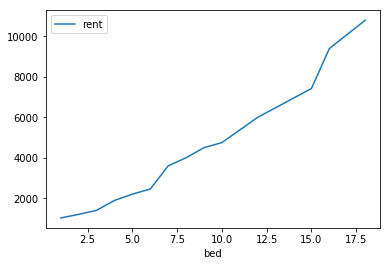

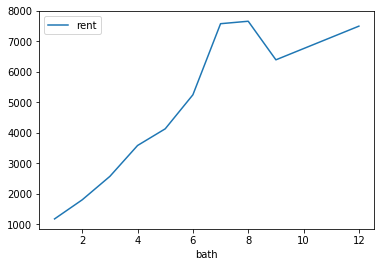

In [31]:
df.groupby('bath').agg('mean').reset_index().plot('bath','rent')

In [ ]:
df.groupby('yearbuilt').agg('median').reset_index().plot('yearbuilt','rent')

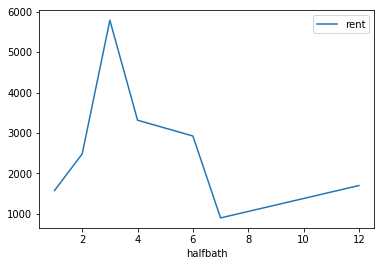

In [30]:
df.groupby('halfbath').agg('mean').reset_index().plot('halfbath','rent')

In [ ]:

list(df)

In [ ]:
df.bed.plot(kind='hist')

In [ ]:
df.rent.plot(kind='hist')

In [ ]:
#print(df.rent.dtype)
import math
df.hospital_miles
df['log_hospital_miles'] = df.hospital_miles.apply(lambda x : math.log(x))
df['log_bed'] = df.bed.apply(lambda x : math.log(x))
for c in list(df):
    print(c,df[c].dtype)
    if df[c].dtype in ['int64','float64']:
        df[c].plot(kind='hist')
        plt.show()
        


In [ ]:
df.info()

In [ ]:
df.groupby('bed').agg('median').reset_index().plot('bed','rent')
df.groupby('log_bed').agg('median').reset_index().plot('log_bed','rent')

In [ ]:
df['log_yearbuilt'] = df.yearbuilt.apply(lambda x: math.log(x))
df.yearbuilt.plot(kind='hist')
plt.show()
df.log_yearbuilt.plot(kind='hist')
df.groupby('yearbuilt').agg('median').reset_index().plot('yearbuilt','rent')
df.groupby('log_yearbuilt').agg('median').reset_index().plot('log_yearbuilt','rent')

In [ ]:
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [ ]:
from scipy import stats
df['box_hospital_miles'] = stats.boxcox(df.hospital_miles)[0]
df['box_HomePrice']= stats.boxcox(df.HomePrice)[0]
df['log_HomePrice'] = df.HomePrice.apply(lambda x : math.log(x))
#df['box_Crime_Rate'] = stats.boxcox(df.Crime_Rate)[0]
df['box_Crime_Rate'] = df.Crime_Rate.apply(lambda x : math.log(x+.01))

df.hospital_miles.plot(kind='hist')
plt.show()
df.box_hospital_miles.plot(kind='hist')
plt.show()

df.HomePrice.plot(kind='hist')
plt.show()
df.box_HomePrice.plot(kind='hist')
plt.show()
df.log_HomePrice.plot(kind='hist')
plt.show()

df.Crime_Rate.plot(kind='hist')
plt.show()
df.box_Crime_Rate.plot(kind='hist')
plt.show()

In [ ]:
df['log_rent'] = df.rent.apply(lambda x :math.log(x))
df['box_rent'] = stats.boxcox(df.rent)[0]

df.rent.plot(kind='hist')
plt.show()
df.log_rent.plot(kind='hist')
plt.show()
df.box_rent.plot(kind='hist')
plt.show()

In [ ]:
df.groupby('log_bed').agg('median').reset_index().plot('log_bed','box_rent')
df.groupby('bed').agg('median').reset_index().plot('bed','rent')